# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.92KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

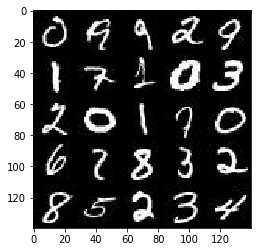

In [4]:
show_n_images = 25
import helper
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

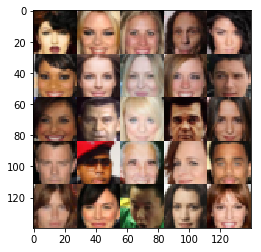

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [45]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learn_rate")  
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [143]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [167]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1,256, 4, strides=1, use_bias=False)
        #x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # First fully connected layer
        #x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        #x1 = tf.reshape(x1, (-1, 7, 7, 256))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now

        #x3 = tf.layers.conv2d_transpose(x1, 128, 4, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now         
            
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x(channels) now
        
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [168]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [169]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [170]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [171]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print_every = 10
    show_every = 100
    alpha = 0.2 
    steps = 0
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    
    with tf.Session() as sess:

        input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
        d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, alpha=alpha)
        d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
        sess.run(tf.global_variables_initializer())
            
        #Train on epochs
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Double value of batch_images
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    #Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1043... Generator Loss: 4.1456
Epoch 1/2... Discriminator Loss: 0.0677... Generator Loss: 11.9335
Epoch 1/2... Discriminator Loss: 0.1198... Generator Loss: 12.3490
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 13.2880
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 0.2774... Generator Loss: 3.9166
Epoch 1/2... Discriminator Loss: 0.1601... Generator Loss: 3.4681
Epoch 1/2... Discriminator Loss: 2.5759... Generator Loss: 12.3689
Epoch 1/2... Discriminator Loss: 0.3082... Generator Loss: 2.5895


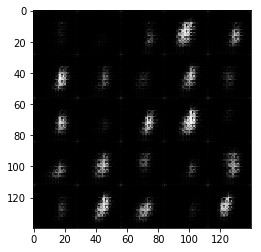

Epoch 1/2... Discriminator Loss: 0.3013... Generator Loss: 2.2787
Epoch 1/2... Discriminator Loss: 0.7013... Generator Loss: 1.1437
Epoch 1/2... Discriminator Loss: 0.4440... Generator Loss: 1.6941
Epoch 1/2... Discriminator Loss: 0.4518... Generator Loss: 2.4763
Epoch 1/2... Discriminator Loss: 1.9603... Generator Loss: 4.1456
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 1.0574
Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 1.6432
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 0.4181... Generator Loss: 2.2838
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.0971


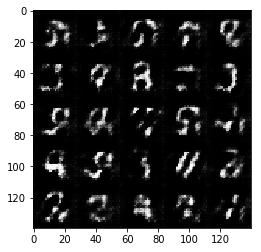

Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 0.9957
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.4317
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.2956
Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 1.3991
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 0.8307... Generator Loss: 1.1630
Epoch 2/2... Discriminator Loss: 1.2108... Generator Loss: 0.9052
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.4572
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 2.5405


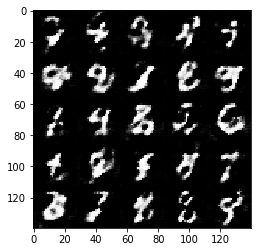

Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 1.5447
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.1795
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.5376
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 1.9307
Epoch 2/2... Discriminator Loss: 0.9106... Generator Loss: 1.8783
Epoch 2/2... Discriminator Loss: 0.9255... Generator Loss: 1.0501


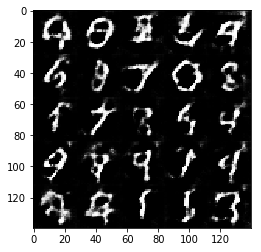

Epoch 2/2... Discriminator Loss: 0.8590... Generator Loss: 1.3963
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.7267
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 1.0636... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 0.9625... Generator Loss: 2.0923
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 2.2687


In [172]:
batch_size = 250
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 3.8044
Epoch 1/1... Discriminator Loss: 0.2281... Generator Loss: 3.0957
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.5473
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 7.6426
Epoch 1/1... Discriminator Loss: 4.0224... Generator Loss: 0.0204
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 10.7901
Epoch 1/1... Discriminator Loss: 1.7262... Generator Loss: 0.2573
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 11.7464
Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 6.9937
Epoch 1/1... Discriminator Loss: 0.2384... Generator Loss: 2.4146


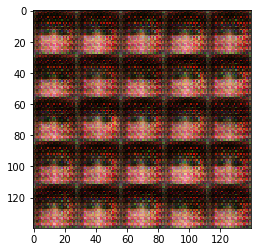

Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 2.5499
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 5.0561
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 2.5792
Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 1.9360
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.5986
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 1.9578


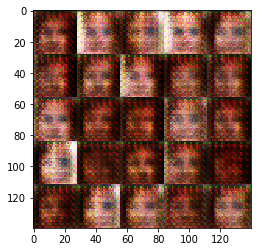

Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.8822
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 2.7340
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 2.4427
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.9867


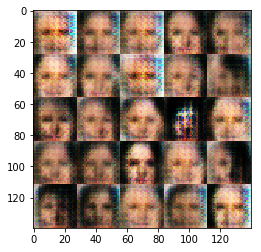

Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 2.7513
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 0.8957


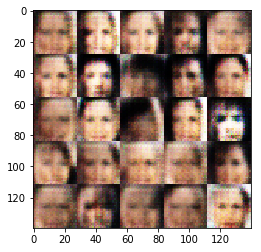

Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.7919
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 2.9165
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 2.5351
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.7668


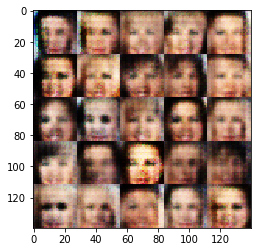

Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 2.0265
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.5607


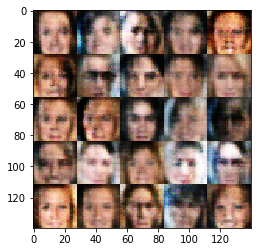

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.3623
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.6294
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.9729... Generator Loss: 0.2271
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4429


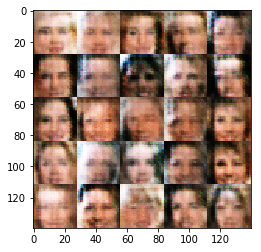

Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0617


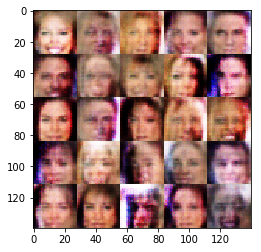

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.4297


In [173]:
batch_size = 250
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.